# Simple grid field overlay #

In this notebook we carry out simple predictions of what grid cells could look like by overlaying grid firing field onto mazes. Essentially, this requires some discretisation of real-world data onto the mazes. We simulate this before data collection by using Solstad et al. (2006) representations implemented in the RatInABox environment.

It should be noted that from the hairpin maze data (Derdikman et al., 2009) that we do NOT expect these representations to match our data. #
Consider this a 'sanity check' or 'null' model.

In [32]:
# @title VScode setup

#Main package dependencies
import numpy as np
import pandas as pd
import networkx as nx

import ratinabox as riab

#Importing files from Peter Doohan's maze codebase:

import functions.representations as mr
import functions.plotting as mp
#Note that functions and packages e.g. plt and nx will be retrievable under plotting

#Bridging networkX maze representations to RatInABox

import functions.mouse_in_a_maze as miam


#Rat in a box implementation

We've written a script to turn a maze into a rat in a box environment.

    • To AUTOMATICALLY save all plots (recommended), set  `ratinabox.autosave_plots = True`
    • To MANUALLY save plots, call                        `ratinabox.utils.save_figure(figure_object, save_title).
      This warning will not be shown again
HINT: You can stylize plots to make them look like repo/paper by calling `ratinabox.stylize_plots()`
      This hint will not be shown again


(<Figure size 4140x414 with 20 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

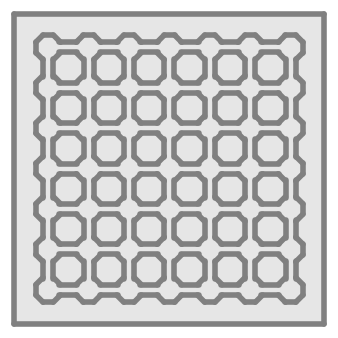

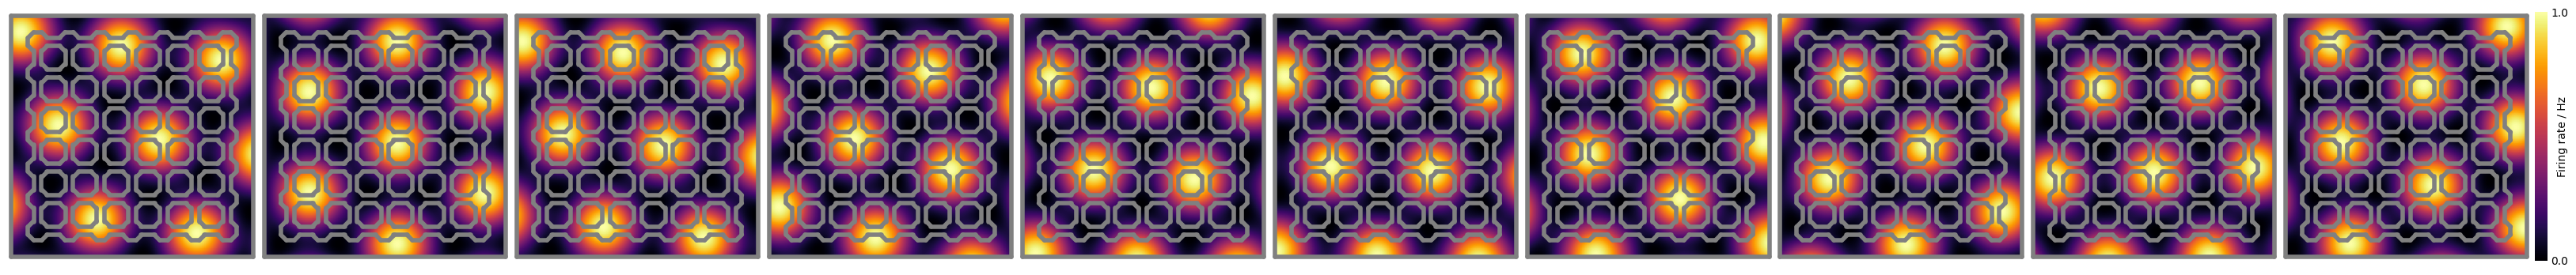

In [34]:
maze = mr.get_simple_maze('FC')
maze_fine = mr.get_extended_simple_maze(maze) #we need the finer-scale for plotting heatmaps in either case.

env = miam.get_maze_env(maze)

env.plot_environment()

Ag = riab.Agent(env, params={"wall_repel_distance": 0.01,
                             "wall_repel_strength":3,
                             "dt": 1/60}) #60Hz framerate

GCs = riab.GridCells(
    Ag,
    params={"n": 10,
            "color": "C2",
            "description": "three_shifted_cosines", #Solstad et al. 2006 equation 2
            "gridscale_distribution":'modules',
            "gridscale":(0.5, )},
)

GCs.plot_rate_map()

In [35]:
np.random.seed(10)

from tqdm import tqdm

Ag.pos = [0.15,0.15] #intialise position inside the maze.
explore_time = 40*60 #time in seconds
for i in (tqdm(range(int(explore_time/ Ag.dt)))): #5 minutes of exploration
    Ag.update()
    GCs.update()


100%|██████████| 144000/144000 [03:54<00:00, 613.79it/s]


(<Figure size 414x414 with 1 Axes>, <Axes: >)

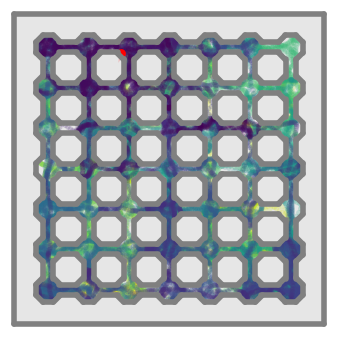

In [36]:
Ag.plot_trajectory(t_start=Ag.t - explore_time, color="changing", alpha=0.2)

(<Figure size 4140x414 with 20 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

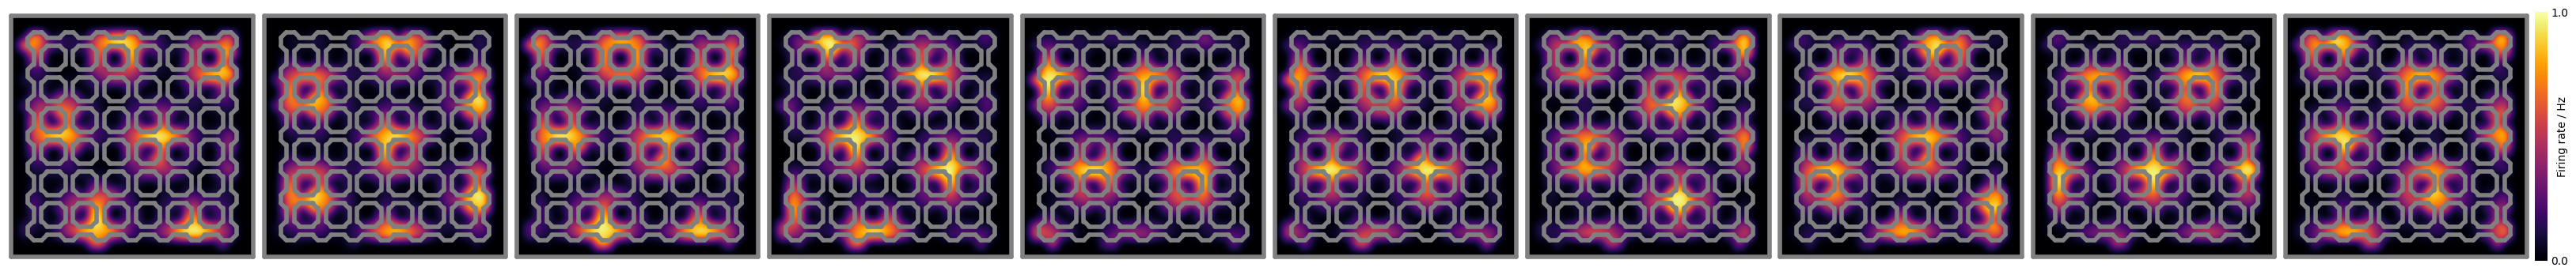

In [37]:
GCs.plot_rate_map(method='history')

## Plotting onto Peter's heatmaps

First with centre firing rate

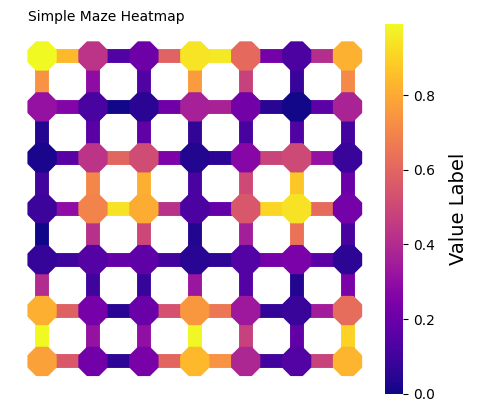

In [12]:
#points = sampling.sample_maze_points(maze, 1000)

centres = mp.nx.get_node_attributes(maze_fine,'position').values()

firingRate = GCs.get_state(evaluate_at='None', pos=list(centres))

label = mp.nx.get_node_attributes(maze_fine,'label').values()

values = mp.pd.Series(data=firingRate[5], index=label)
values.index.name='maze_position' #Further required for the plot function to work

fig, ax = mp.plt.subplots()
ax.axis('off')

mp.plot_simple_heatmap(maze, values, ax)

#test = env.sample_positions(n=1000)
#x,y = zip(*test)
#mp.plt.scatter(x, y)

We also want to take the average firing rate within each tower or bridge.
I wonder if Peter has code for that.

He does. The trick is to map the firing rate at a set of coordinates to the nearest neighbour (node or edge centre).

In [ ]:
Agent_data = pd.DataFrame(Ag.history)
Grid_cell_data = pd.DataFrame(GCs.history)

data = pd.merge(Agent_data,Grid_cell_data) #merges by shared columns (t)

#Nearest neighbour from https://stackoverflow.com/questions/57129448/find-distance-to-nearest-neighbor-in-2d-array

from scipy.spatial.distance import cdist

def nearest_neighbour_pos(agent_positions,maze_positions):
  #INPUT:
    dists = cdist(agent_positions,maze_positions)
    nn_dist = np.sort(dists)[0]
    return nn_dist



In [ ]:
#Using Peter's functions:

from scipy.spatial import KDTree

def get_position2simple_coord_dict(simple_maze):
    """Get a dictionary mapping maze node/edge positions to maze node/edge coordinates"""
    position2simple_node = {tuple(position):node for node, position in simple_maze.nodes(data='position')}
    position2simple_edge={tuple(position):(node1, node2) for node1,node2,position in simple_maze.edges(data='position')}
    position2simple_coord = position2simple_node.copy(); position2simple_coord.update(position2simple_edge)
    return position2simple_coord

def get_nearest_simple_coord(centroid_positions, maze):
    """Get the nearest maze node for each position in the centroid_positions array."""
    position2maze_coord = get_position2simple_coord_dict(maze)
    coord_positions = list(position2maze_coord.keys())
    kd_tree = KDTree(coord_positions) #Create a KDTree from the maze coord positions
    _, nearest_node_indices = kd_tree.query(centroid_positions) # Query the KDTree to get the nearest maze node for each position
    nearest_nodes = [position2maze_coord[tuple(coord_positions[i])] for i in nearest_node_indices]
    return nearest_nodes


agent_positions = list(Agent_data.pos)

nearest_pos = get_nearest_simple_coord(agent_positions, maze)

data = data.assign(nn_maze = nearest_pos)

#OBS: may just ask Peter for the standard data format. That'll be faster.

NameError: name 'Agent_data' is not defined

# Autocorrelograms and gridness

Here we just want to spend some time figuring out autocorrelograms and gridness scores.

We want to compare output from an open field to output from a maze.

In particular we will be using scores.py, as written for Banino et al,. 2018 (deepmind nature paper).

In [ ]:
Ag_df = pd.DataFrame(Ag.history)
GCs_df = pd.DataFrame(GCs.history)

def get_simulated_navigation_rates_df(sim_ID, moving_threshold=0.1):
    # convert to our standardised data format
    grid_cell_navigation_rates = GCs_df.firingrate.apply(pd.Series)
    rates_df = pd.concat(
        [grid_cell_navigation_rates], axis=1
    )
    rates_df = rates_df.sample(frac=1, axis=1)  # shuffle cells for labelling
    rates_df.columns = pd.MultiIndex.from_product(
        [["firing_rate"], [f"sim_cluster_{i}" for i in range(rates_df.shape[1])]]
    )
    navigation_df = pd.DataFrame()
    navigation_df[("time", "")] = Ag_df.t
    navigation_df[("subject_ID", "")] = sim_ID
    navigation_df[("session_ID", "")] = np.nan
    navigation_df[("head_direction", "")] = Ag_df.head_direction.apply(
        direction_to_angle
    )
    centroid_positions = Ag_df.pos.apply(pd.Series)
    navigation_df[("centroid_position", "x")] = centroid_positions[0]
    navigation_df[("centroid_position", "y")] = centroid_positions[1]
    velocity = Ag_df.vel.apply(pd.Series)
    navigation_df[("velocity", "x")] = velocity[0]
    navigation_df[("velocity", "y")] = velocity[1]
    speed = Ag_df.vel.apply(np.linalg.norm)
    navigation_df[("speed", "")] = speed
    navigation_df[("moving", "")] = speed > moving_threshold
    navigation_rates_df = pd.concat([navigation_df, rates_df], axis=1)
    navigation_rates_df.columns = pd.MultiIndex.from_tuples(navigation_rates_df.columns)
    return navigation_rates_df


# %% Supporting functinos


def direction_to_angle(direction):
    x, y = direction
    angle_rad = np.arctan2(y, x)
    angle_deg = np.degrees(angle_rad)
    adjusted_angle = (450 - angle_deg) % 360  # Adjusting for true North (x=0, y=1)
    return adjusted_angle


# %% Heatmap functions


def firing_rate_heatmap(trajectory, firing_rates, bin_size=0.02):
    """
    Generates a heatmap of average firing rates in a 1x1m arena.

    :param trajectory: List of tuples containing (x, y) coordinates.
    :param firing_rates: List of firing rates corresponding to each point in the trajectory.
    :param bin_size: Size of the bin in meters. Default is 0.01m (1cm).
    :return: A heatmap of average firing rates.
    """

    # Discretize the arena into bins
    num_bins = int(1 / bin_size)
    heatmap_data = np.zeros((num_bins, num_bins))

    # Count and sum of firing rates for each bin
    count = np.zeros_like(heatmap_data)
    sum_rates = np.zeros_like(heatmap_data)

    # Map trajectory points to bins and accumulate firing rates
    for (x, y), rate in zip(trajectory, firing_rates):
        if 0 <= x < 1 and 0 <= y < 1:  # Ensure the point is within the arena
            bin_x = int(x / bin_size)
            bin_y = int(y / bin_size)
            count[bin_x, bin_y] += 1
            sum_rates[bin_x, bin_y] += rate

    # Avoid division by zero
    with np.errstate(divide="ignore", invalid="ignore"):
        heatmap_array = np.true_divide(sum_rates, count)

    return heatmap_array


def plot_open_field_heatmap2(heatmap_array):
    # Plotting the heatmap
    f, ax = plt.subplots(figsize=(4, 4))
    ax.set_aspect("equal")
    # Draw heatmap
    hm = sns.heatmap(
        heatmap_array,
        cmap="plasma",
        vmin=0,
        ax=ax,
        xticklabels=False,
        yticklabels=False,
    )
    # Invert y-axis to match the coordinate system
    ax.invert_yaxis()
    cbar = hm.collections[0].colorbar
    # Resize the colorbar
    cbar.ax.set_aspect(15)
    return



In [ ]:
DF = get_simulated_navigation_rates_df(1)



In [ ]:
DF

time subject_ID session_ID head_direction centroid_position  \
                                                                         x   
0          0.016667          1        NaN     151.964507          0.150727   
1          0.033333          1        NaN     151.452879          0.150872   
2          0.050000          1        NaN     150.537977          0.151054   
3          0.066667          1        NaN     149.198259          0.152374   
4          0.083333          1        NaN     147.643590          0.153761   
...             ...        ...        ...            ...               ...   
143997  2399.966667          1        NaN     243.999498          0.685596   
143998  2399.983333          1        NaN     250.742081          0.684474   
143999  2400.000000          1        NaN     257.132759          0.683481   
144000  2400.016667          1        NaN     263.041080          0.682295   
144001  2400.033333          1        NaN     268.515000          0.680992   

                  velocity               speed moving   firing_rate  \
               y         x         y                  sim_cluster_0   
0       0.148718  0.043626 -0.076910  0.088422  False      0.167764   
1       0.148639  0.052305 -0.081650  0.096967  False      0.167929   
2       0.148591  0.063255 -0.084552  0.105594   True      0.168010   
3       0.147103  0.079204 -0.089266  0.119339   True      0.171398   
4       0.145711  0.083218 -0.083532  0.117910   True      0.174533   
...          ...       ...       ...       ...    ...           ...   
143997  0.283181 -0.060662  0.077922  0.098751  False      0.227935   
143998  0.284551 -0.067364  0.082219  0.106292   True      0.223278   
143999  0.285737 -0.059545  0.071123  0.092759  False      0.219263   
144000  0.287076 -0.071178  0.080389  0.107372   True      0.214737   
144001  0.288536 -0.078164  0.087596  0.117400   True      0.209820   

                                                                              \
       sim_cluster_1 sim_cluster_2 sim_cluster_3 sim_cluster_4 sim_cluster_5   
0           0.257233      0.103757      0.370676      0.326010      0.107689   
1           0.257363      0.103855      0.370183      0.326588      0.107442   
2           0.257676      0.103978      0.369791      0.327339      0.107198   
3           0.256584      0.104991      0.361874      0.332270      0.104046   
4           0.255872      0.106241      0.354331      0.337487      0.101103   
...              ...           ...           ...           ...           ...   
143997      0.321384      0.248240      0.106183      0.238134      0.110654   
143998      0.320346      0.254462      0.109673      0.236089      0.110324   
143999      0.319323      0.259967      0.112761      0.234215      0.109989   
144000      0.317874      0.266401      0.116356      0.231852      0.109539   
144001      0.316197      0.273547      0.120347      0.229200      0.108985   

                                                                
       sim_cluster_6 sim_cluster_7 sim_cluster_8 sim_cluster_9  
0           0.154969      0.155087      0.289373      0.341630  
1           0.155366      0.154790      0.289882      0.340975  
2           0.155743      0.154558      0.290579      0.340344  
3           0.161318      0.149712      0.294386      0.331513  
4           0.166855      0.145138      0.298525      0.322953  
...              ...           ...           ...           ...  
143997      0.985268      0.098265      0.014996      0.008830  
143998      0.983073      0.100713      0.015852      0.009274  
143999      0.981022      0.102876      0.016637      0.009735  
144000      0.978484      0.105390      0.017558      0.010373  
144001      0.975523      0.108173      0.018627      0.011167  

[144002 rows x 20 columns]

In [ ]:
firing_rate_heatmap(Ag.history['pos'],GCs.history['firingrate'])

TypeError: 'zip' object is not callable